In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
#import tensorflow as tf
#from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
#from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error


wrangleData = True
processCardText = True
loadInventoryFromFile = False
reduceDataSetSize = True
createHoldoutData = True
performDataExploration = False

### Initial Data Wrangling & Database Consolidation

In [2]:
"""Transform competitor inventory data into a structured DataFrame.
Arguments:
    theCompetitorData (DataFrame): Input DataFrame with 'history' column.
    maxNumberOfRows (int, optional): Limits number of rows to process. Defaults to all rows.
Returns:
    DataFrame: Transformed inventory data.
"""
def createDataFrameFromInventories(theCompetitorData, maxNumberOfRows=None):
    rows = []
    price_memory = {}

    # Determine row processing limit
    total_rows = len(theCompetitorData)
    rows_to_process = min(total_rows, maxNumberOfRows) if maxNumberOfRows is not None else total_rows
    progress_step = max(rows_to_process * 2 // 100, 1)

    for i in range(rows_to_process):
        row = theCompetitorData.iloc[i]
        history_entries = row['history'].split('|')
        key = (row['competitorName'], row['cardNumber'])

        for entry in history_entries:
            try:
                price, qty, date = entry.split('*')

                if price.strip().lower() == 'sold out':
                    if key in price_memory:
                        clean_price = price_memory[key]
                    else:
                        continue
                else:
                    price = price.replace(',', '').strip()
                    clean_price = float(price)
                    price_memory[key] = clean_price

                clean_qty = int(qty) if qty.isdigit() else 0
                rows.append({
                    'competitorName': row['competitorName'],
                    'cardNumber': row['cardNumber'],
                    'price': clean_price,
                    'qty': clean_qty,
                    'history': date
                })
            except ValueError as e:
                print(f"Skipping card #{row['cardNumber']}, malformed entry: {entry} → {e} ({history_entries})")
        
        # Show progress
        if (i + 1) % progress_step == 0 or i + 1 == rows_to_process:
            percent = ((i + 1) / rows_to_process) * 100
            print(f"Processed {i + 1}/{rows_to_process} rows ({percent:.1f}%)")

    inventoryData = pd.DataFrame(rows)
    return inventoryData



In [7]:
if wrangleData == True:
    # Load directly into a DataFrame
    print(f"!!!!!: Loading data files")
    theCardData = pd.read_csv('data/magic_cards.csv', encoding='utf-8')
    theEditionData = pd.read_csv('data/editions.csv', encoding='utf-8')
    theCompetitorData = pd.read_csv('data/competitorInventories.csv', encoding='utf-8')

    print(f"!!!!!: Wrangling card data")
    # Filter on specific rows
    cardData = theCardData[
        (theCardData['status'] == 'Active') & # Only non-deleted inventory
        (theCardData['type'] == 'Normal') & # Non-foils
        (theCardData['true_rarity'] != 'Basic Land') & # Basic Lands prices rarely change ovr time, including them would skew the data
        (theCardData['true_rarity'] != 'Common') & # Commons are in too great abundance to yield the greatest returns on the investment
        (theCardData['true_rarity'] != 'Uncommon') & # Commons are in too great abundance to yield the greatest returns on the investment
        (theCardData['2nd_converted_casting_cost'] == 0) & # Remove dual cards as there aren't enough of them and they could skew results.
        (~theCardData['spelltype'].astype(str).str.startswith('Planeswalker')) & # Remove all planeswalkers from the data set
        (theCardData['language_number'] == 1) # Only english versions
    ]

    editionData = theEditionData[
        (theEditionData['status'] == 'Active') # Only non-deleted editions
    ]

    editionData = editionData[['number', 'release_date']]

    # Remove fields associated with dual cards
    cardData = cardData.drop(['2nd_name', '2nd_casting_b', '2nd_casting_u', '2nd_casting_g', '2nd_casting_r', '2nd_casting_w', '2nd_casting_bu', '2nd_casting_bg', '2nd_casting_br', '2nd_casting_bw', '2nd_casting_ug', '2nd_casting_ur', '2nd_casting_uw', '2nd_casting_gr', '2nd_casting_gw', '2nd_casting_rw', '2nd_casting_2b', '2nd_casting_2u', '2nd_casting_2g', '2nd_casting_2r', '2nd_casting_2w', '2nd_casting_bp', '2nd_casting_up', '2nd_casting_gp', '2nd_casting_rp', '2nd_casting_wp', '2nd_casting_colorless', '2nd_casting_x', '2nd_converted_casting_cost', '2nd_color', '2nd_spelltype', '2nd_power', '2nd_toughness', '2nd_text', '2nd_flavortext', '2nd_artist_number'], axis=1)

    # Remove fields with no real value
    cardData = cardData.drop(['artist_number', 'flavortext', 'last_modification_date', 'publisher_id', 'status', 'is_always_foil', 'weight', 'image_numbers', 'language_number', 'price', 'type'], axis=1)

    # Clean up various NaN values
    cardData[['power', 'toughness', 'casting_2b', 'casting_2u', 'casting_2g', 'casting_2r', 'casting_2w', 'casting_bp', 'casting_up', 'casting_gp', 'casting_rp', 'casting_wp']] = cardData[['power', 'toughness', 'casting_2b', 'casting_2u', 'casting_2g', 'casting_2r', 'casting_2w', 'casting_bp', 'casting_up', 'casting_gp', 'casting_rp', 'casting_wp']].fillna(0)
    cardData['color'] = cardData['color'].fillna('Unknown')
    cardData['spelltype'] = cardData['spelltype'].fillna('Unknown')
    
    # Recalculate converted casting cost after NaN cleanup
    cardData['converted_casting_cost'] = cardData[
        ["casting_b", "casting_u", "casting_g", "casting_r", "casting_w",
        "casting_bu", "casting_bg", "casting_br", "casting_bw",
        "casting_ug", "casting_ur", "casting_uw",
        "casting_gr", "casting_gw", "casting_rw"]
    ].sum(axis=1)

    # Fix a couple of issues with the data where the cards don't have a true_rarity set
    #cardData.loc[cardData['name'].isin(['Platinum Angel', 'Bogardan Hellkite']), 'true_rarity'] = 'Mythic Rare'
    #print(cardData['true_rarity'].unique())

    # Convert rarity to a frequency
    mythicEditions = {60, 15, 1, 78, 79, 34, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 108, 109, 123, 128, 143, 144, 145, 146, 156, 157}
    isMythic = cardData["edition_number"].isin(mythicEditions)
    cardData.loc[isMythic, "frequency"] = np.select(
        [
            cardData.loc[isMythic, "true_rarity"] == "Common",
            cardData.loc[isMythic, "true_rarity"] == "Uncommon",
            cardData.loc[isMythic, "true_rarity"] == "Rare",
            cardData.loc[isMythic, "true_rarity"] == "Mythic Rare"
        ],
        [792/1080, 216/1080, 63/1080, 9/1080],
        default=np.nan
    )
    cardData.loc[~isMythic, "frequency"] = np.select(
        [
            cardData.loc[~isMythic, "true_rarity"] == "Common",
            cardData.loc[~isMythic, "true_rarity"] == "Uncommon",
            cardData.loc[~isMythic, "true_rarity"] == "Rare"
        ],
        [11/15, 3/15, 1/15],
        default=np.nan
    )

    # Add columns based upon card text
    if processCardText == True:
        mtgAbilities = ["Affinity", "Aftermath", "Adventure", "Cascade", "Companion", "Convoke", "Cycling", "Cumulative Upkeep", "Deathtouch", "Delve", "Defender", "Double Strike", "Echo", "Enchant", "Encore", "Equip", "Escalate", "Escape", "Exalted", "Exploit", "Evolve", "Extort", "First Strike", "Flash", "Flashback", "Flanking", "Flying", "Foretell", "Haste", "Hexproof", "Indestructible", "Infect", "Intimidate", "Landwalk", "Lifelink", "Megamorph", "Menace", "Miracle", "Morph", "Mutate", "Persist", "Phasing", "Protection", "Prowess", "Rampage", "Reach", "Scry", "Shadow", "Shroud", "Split Second", "Suspend", "Toxic", "Trample", "Undying", "Vigilance"]
        for ability in mtgAbilities:
            col_name = f'ability{ability.replace(" ", "")}'  # Remove spaces for column naming
            pattern = rf'\b{ability.lower()}\b'              # Match whole word, case-insensitive
            cardData[col_name] = cardData['text'].str.contains(pattern, case=False, na=False).astype(int)

        cardData['hasActivatedAbility'] = cardData['text'].str.contains(r"<IMG SRC", case=False, na=False).astype(int)
        cardData['canBeSacrificed'] = cardData['text'].str.contains(r"sacrifice", case=False, na=False).astype(int)

        
        # Create a flag just to tell if the card has text or not. If a card has text then it is likely to have additional powers that make it more valuable
        #cardData['hasText'] = cardData['text'].notna() & cardData['text'].str.strip().ne('')
        #cardData['hasText'] = cardData['hasText'].astype(int)

        # Print out the results to check if hasText was accurately identified
        #total_has_text = cardData['hasText'].sum()
        #print(cardData.loc[:49, 'text'])  # Select rows 0 through 9 for 'text' column

        #print(f"{total_has_text} out of {len(cardData)} rows have card text.")
        #import sys
        #sys.exit("Exited from some_function")

    # Remove text field after processing
    cardData = cardData.drop(['text'], axis=1)

    # Convert any instances of pwoer or tougness to a numeric value. These could skew results so I might want to omit those records altogether
    cardData['power'] = cardData['power'].replace('*', 2.5)
    cardData['toughness'] = cardData['toughness'].replace('*', 2.5)
    
    # Remove any records where the power or toughness are not numeric.
    cardData['power_numeric'] = pd.to_numeric(cardData['power'], errors='coerce')
    cardData['toughness_numeric'] = pd.to_numeric(cardData['toughness'], errors='coerce')
    cardData = cardData[cardData[['power_numeric', 'toughness_numeric']].notna().all(axis=1)]
    cardData = cardData.drop(columns=['power_numeric', 'toughness_numeric'])
    cardData['power'] = pd.to_numeric(cardData['power'], errors='coerce')
    cardData['toughness'] = pd.to_numeric(cardData['toughness'], errors='coerce')

    # Remove any instances where power or toughness are negative numbers. I don't think that there are any legitimate instances.
    cardData = cardData[
        (cardData['power'] >= 0) & 
        (cardData['power'] <= 10) & # Remove outliers
        (cardData['toughness'] >= 0) &
        (cardData['toughness'] <= 10) # Remove outliers
    ]

    # unique_values = cardData["power"].dropna().unique().tolist()
    # print(unique_values)

    print(f"!!!!!: Merging card and edition data")
    mergedData = pd.merge(
        cardData, 
        editionData, 
        left_on='edition_number', 
        right_on='number', 
        how='inner'
    )

    mergedData = mergedData.drop(['number_y', 'true_rarity'], axis=1)

    # # Get a list of editions that had mythic rares
    # mergedData['release_date'] = pd.to_datetime(mergedData['release_date'], format='%Y%m%d', errors='coerce')
    # filtered = mergedData[mergedData["release_date"] >= datetime(2008, 10, 1)]
    # unique_editions = filtered["edition_number"].dropna().unique().tolist()
    # print(unique_editions)
    
    #checkingData = mergedData[
    #    (mergedData['abilityShadow'] == 1)
    #    (mergedData['number_x'] == 21841)
    #]

    if loadInventoryFromFile:
        print(f"!!!!!: Loading inventory data file")
        inventoryData = pd.read_csv('data/cleanedInventoryData.csv', encoding='utf-8')
    else:
        print(f"!!!!!: Wrangling inventory data and saving the results to a file")
        inventoryData = createDataFrameFromInventories(theCompetitorData)
        inventoryData.to_csv('data/cleanedInventoryData.csv', index=False, encoding='utf-8')    

    print(f"!!!!!: Performing final merge")
    finalMergedData = pd.merge(
        inventoryData, 
        mergedData, 
        left_on='cardNumber', 
        right_on='number_x', 
        how='inner'
    )
    
    print(f"!!!!!: Performing card age calculations")
    # Force conversion and coerce invalid entries to NaT
    finalMergedData['release_date'] = pd.to_datetime(finalMergedData['release_date'], format='%Y%m%d', errors='coerce')
    finalMergedData['history'] = pd.to_datetime(finalMergedData['history'], format='%Y%m%d', errors='coerce')
    # Drop any records where the date is unknown as the data is suspect
    finalMergedData.dropna(subset=['release_date', 'history'], inplace=True)

    # Filter out cards released before September 1994 (The really rare and expensive editions)
    cutoff_date = pd.Timestamp('1994-09-01')
    finalMergedData = finalMergedData[finalMergedData['release_date'] >= cutoff_date]

    #finalMergedData['release_date'] = pd.to_datetime(finalMergedData['release_date'], format='%Y%m%d')
    #finalMergedData['history'] = pd.to_datetime(finalMergedData['history'], format='%Y%m%d')
    finalMergedData['daysSinceRelease'] = (finalMergedData['history'] - finalMergedData['release_date']).dt.days
    originalGameDate = pd.Timestamp('1993-01-01')
    finalMergedData['daysSinceGameRelease'] = (finalMergedData['history'] - originalGameDate).dt.days

    finalMergedData = finalMergedData.drop(['number_x', 'cardNumber', 'history', 'edition_number', 'release_date'], axis=1)

    finalMergedData = finalMergedData[
        (finalMergedData['price']  < 20) &
        (finalMergedData['price']  > 0.26) & 
        (finalMergedData['frequency']  > 0) # Only elements with a known frequency. There are a couple of promo cards that will skew the results
    ]

    # Save wrangled data to a file
    print(f"!!!!!: Saving final data to a file")
    finalMergedData.to_csv('data/wrangledData.csv', index=False, encoding='utf-8') 

    # missing_counts = finalMergedData.isna().sum()
    # print(missing_counts[missing_counts > 0])
    # print(cardData['true_rarity'].dropna().unique())
    #print(cardData['true_rarity'].unique())


    # List of remaining columns
    #print(cardData.columns.tolist())
    #print(editionData.columns.tolist())
    #print(mergedData.columns.tolist())
    #print(theCompetitorData.columns.tolist())

    # View the first 5 rows
    #print(cardData.head(5))
    #print(mergedData.head(30))
    #print(checkingData.head(5))
    #print(inventoryData.head(20))
    #print(finalMergedData.head(10))
    


!!!!!: Loading data files


C:\Users\consu\AppData\Local\Temp\ipykernel_25424\2697126261.py:4: DtypeWarning: Columns (76,79) have mixed types. Specify dtype option on import or set low_memory=False.
  theCardData = pd.read_csv('data/magic_cards.csv', encoding='utf-8')


!!!!!: Wrangling card data
!!!!!: Merging card and edition data
!!!!!: Wrangling inventory data and saving the results to a file
Processed 8337/416884 rows (2.0%)
Processed 16674/416884 rows (4.0%)
Processed 25011/416884 rows (6.0%)
Processed 33348/416884 rows (8.0%)
Processed 41685/416884 rows (10.0%)
Processed 50022/416884 rows (12.0%)
Processed 58359/416884 rows (14.0%)
Processed 66696/416884 rows (16.0%)
Processed 75033/416884 rows (18.0%)
Processed 83370/416884 rows (20.0%)
Processed 91707/416884 rows (22.0%)
Processed 100044/416884 rows (24.0%)
Processed 108381/416884 rows (26.0%)
Processed 116718/416884 rows (28.0%)
Processed 125055/416884 rows (30.0%)
Processed 133392/416884 rows (32.0%)
Skipping card #0, malformed entry: 0.09* → not enough values to unpack (expected 3, got 2) (['0.25*20*20150930', '0.09*31*20130625', '0.09*24*20130625', '0.57*7*20130625', '1.01*14*20130625', '0.36*4*20130625', '0.09*65*20130625', '0.14*19*20130625', '2.85*1*20130625', '0.29*16*20130625', '15.4

### Separate the data into training and holdout sets

In [27]:
if reduceDataSetSize:
    print(f"!!!!!: Loading the wrangled data")
    # Data set is too large, creating a smaller sampling of the data
    theData = pd.read_csv("data/wrangledData.csv")
    sampleSize = 0.60
    print(f"!!!!!: Splitting off {sampleSize * 100}% of the data, otherwise the data set is too large to utilize.")
    sampledData = theData.sample(frac=sampleSize, random_state=42)
    sampledData.to_csv("data/sampledData.csv", index=False)

if createHoldoutData:
    print(f"!!!!!: Loading the sampled data")

    holdoutFraction = 0.2
    # Load the dataset
    theData = pd.read_csv("data/sampledData.csv")

    print(f"!!!!!: Splitting off a holdout set of size {holdoutFraction * 100}%. There are {len(theData)} records.")
    # Create holdout (20%)
    holdout = theData.sample(frac=holdoutFraction, random_state=42)

    # Create training (remaining 80%)
    training = theData.drop(holdout.index)

    # Optional: save to files
    holdout.to_csv("data/holdout.csv", index=False)
    training.to_csv("data/training.csv", index=False)


!!!!!: Loading the wrangled data
!!!!!: Splitting off 60.0% of the data, otherwise the data set is too large to utilize.
!!!!!: Loading the sampled data
!!!!!: Splitting off a holdout set of size 20.0%. There are 1867787 records.


#### Data Exploration Functions

In [5]:
def graphCategoricalVsTarget(theData, targetValue, limit=None):
    categoricalData = theData.select_dtypes(include='object').columns
    if isinstance(limit, int) and limit > 0:
        categoricalData = categoricalData[:limit]

    for col in categoricalData:
        if col.endswith('-orig'):
            continue
        plt.figure(figsize=(8, 6))
        sns.barplot(x=targetValue, y=col, data=theData)
        plt.title(f"Our Target vs {col}")
        plt.xlabel('% Conversion')
        plt.ylabel('')
        plt.show()

def graphNumericalVsTarget(theData, targetValue, limit=None):
    numericalData = theData.select_dtypes(include=['int64', 'float64']).columns
    if isinstance(limit, int) and limit > 0:
        numericalData = numericalData[:limit]

    for col in numericalData:
        if col.endswith('-orig'):
            continue
        plt.figure(figsize=(8, 6))
        sns.barplot(x=col, y=targetValue, data=theData)
        plt.title(f"Our Target vs {col}")
        plt.ylabel('% Conversion')
        plt.xlabel('')
        plt.xticks(rotation=45)
        plt.show()

#### Data Exploration Graphs

In [33]:
theTrainingData = pd.read_csv("data/training.csv")
if performDataExploration:
    print(f"!!!!!: Performing data exploration")
    graphCategoricalVsTarget(theTrainingData, 'price')
    #graphNumericalVsTarget(theTrainingData, 'price')

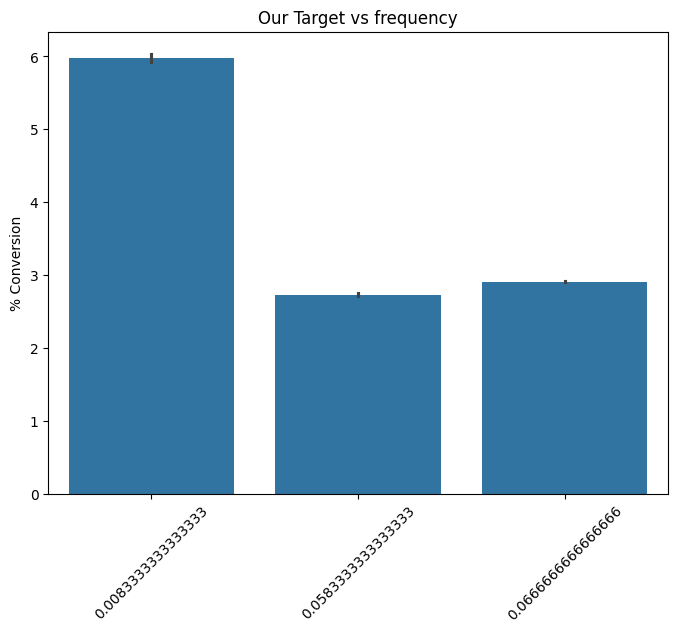

In [30]:
targetValue = "price"
col = "frequency"
plt.figure(figsize=(8, 6))
sns.barplot(x=col, y=targetValue, data=theTrainingData)
plt.title(f"Our Target vs {col}")
plt.ylabel('% Conversion')
plt.xlabel('')
plt.xticks(rotation=45)
plt.show()

### Select, Encode and Build Model

In [31]:
def applyXGBoost(df, features, target, showHeader=True, test_size=0.2, random_state=42, n_estimators=250, max_depth=5, learning_rate=0.1):
    X_train, X_test, y_train, y_test = train_test_split(
        df[features], df[target], test_size=test_size, random_state=random_state
    )

    xgb_model = xgb.XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        random_state=random_state,
#        reg_alpha=0.1,
#        reg_lambda=1.0
#        subsample=0.8,
   #     colsample_bytree=0.8
    )
    xgb_model.fit(X_train,y_train)
    y_pred = xgb_model.predict(X_test)
    xgb_r2 = r2_score(y_test, y_pred)
    xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    feature_str = ", ".join(features)

    if showHeader:
        print("\n====================================")
        print(f"Features: {feature_str}")
        print(f"Target: {target}")
        print(f"Test Size: {test_size}")
        print(f"Random State: {random_state}")
        print(f"n_estimators: {n_estimators}")
        print(f"max_depth: {max_depth}")
        print(f"learning_rate: {learning_rate}")
        print("====================================\n")
    print(f"XGBoost R2 Score: {xgb_r2:.4f} | Root Mean Squared Error: {xgb_rmse:.4f}")

def applyXGBoostByFeature(df, feature_name, features, target, test_size=0.2, random_state=42, n_estimators=250, max_depth=5, learning_rate=0.1, threshold=0.4):
  feature_vals = df[feature_name].unique()

  for val in feature_vals:
    df_val_instances = df[df[feature_name] == val]
    record_count = len(df_val_instances)

    print(f"\n=== Processing Feature Value: {val} | Records: {record_count} ===")
    applyXGBoost(df_val_instances, features, target, False, test_size, random_state, n_estimators, max_depth, learning_rate)

In [34]:
features = [
        #'competitorName',
        #'price', # this is our target variable
        #'qty',
        'casting_b',
        'casting_u',
        'casting_g',
        'casting_r',
        'casting_w',
        # 'casting_bu',
        # 'casting_bg',
        # 'casting_br',
        # 'casting_bw',
        # 'casting_ug',
        # 'casting_ur',
        # 'casting_uw',
        # 'casting_gr',
        # 'casting_gw',
        # 'casting_rw',
        # 'casting_2b',
        # 'casting_2u',
        # 'casting_2g',
        # 'casting_2r',
        # 'casting_2w',
        # 'casting_bp',
        # 'casting_up',
        # 'casting_gp',
        # 'casting_rp',
        # 'casting_wp',
        #'casting_colorless',
        'casting_x',
        #'converted_casting_cost',
        #'color', # Not needed as spelltype can be determined by the casting cost variables
        #'spelltype',
        'power',
        'toughness',
        'frequency',
        'abilityAffinity',
        'abilityAftermath',
        'abilityAdventure',
        'abilityCascade',
        'abilityCompanion',
        'abilityConvoke',
        'abilityCycling',
        'abilityCumulativeUpkeep',
        'abilityDeathtouch',
        'abilityDelve',
        'abilityDefender',
        'abilityDoubleStrike',
        'abilityEcho',
        'abilityEnchant',
        'abilityEncore',
        'abilityEquip',
        'abilityEscalate',
        'abilityEscape',
        'abilityExalted',
        'abilityExploit',
        'abilityEvolve',
        'abilityExtort',
        'abilityFirstStrike',
        'abilityFlash',
        'abilityFlashback',
        'abilityFlanking',
        'abilityFlying',
        'abilityForetell',
        'abilityHaste',
        'abilityHexproof',
        'abilityIndestructible',
        'abilityInfect',
        'abilityIntimidate',
        'abilityLandwalk',
        'abilityLifelink',
        'abilityMegamorph',
        'abilityMenace',
        'abilityMiracle',
        'abilityMorph',
        'abilityMutate',
        'abilityPersist',
        'abilityPhasing',
        'abilityProtection',
        'abilityProwess',
        'abilityRampage',
        'abilityReach',
        'abilityScry',
        'abilityShadow',
        'abilityShroud',
        'abilitySplitSecond',
        'abilitySuspend',
        'abilityToxic',
        'abilityTrample',
        'abilityUndying',
        'abilityVigilance',
        'daysSinceRelease',
        'daysSinceGameRelease',
        'hasActivatedAbility',
        'canBeSacrificed'
    ]



target = "price"
#applyXGBoost(theTrainingData, features, "price", True, 0.2, 42, 250, 6, 0.05)
#applyXGBoost(theTrainingData, features, "price", True, 0.2, 42, 500, 6, 0.1) #R2 Score: 0.3143 | Root Mean Squared Error: 2.7325
#applyXGBoost(theTrainingData, features, "price", True, 0.2, 42, 1000, 6, 0.1) #R2 Score: 0.3463 | Root Mean Squared Error: 2.6681
#applyXGBoost(theTrainingData, features, "price", True, 0.2, 42, 500, 6, 0.05) #R2 Score: 0.2841 | Root Mean Squared Error: 2.7922
#applyXGBoost(theTrainingData, features, "price", True, 0.2, 42, 500, 6, 0.2) #R2 Score: 0.3485 | Root Mean Squared Error: 2.6636
#applyXGBoost(theTrainingData, features, "price", True, 0.2, 42, 1000, 6, 0.2) #R2 Score: 0.3755 | Root Mean Squared Error: 2.6078
#applyXGBoost(theTrainingData, features, "price", True, 0.2, 42, 1000, 6, 0.1) #R2 Score: 0.3463 | Root Mean Squared Error: 2.6681
#applyXGBoost(theTrainingData, features, "price", True, 0.2, 42, 1500, 6, 0.2) #R2 Score: 0.3886 | Root Mean Squared Error: 2.5804
#applyXGBoost(theTrainingData, features, "price", True, 0.2, 42, 1500, 6, 0.2) # All abilities - R2 Score: 0.4476 | Root Mean Squared Error: 2.4526
#applyXGBoost(theTrainingData, features, "price", True, 0.2, 42, 1500, 6, 0.1) # All abilities - R2 Score: 0.4159 | Root Mean Squared Error: 2.5220
#applyXGBoost(theTrainingData, features, "price", True, 0.2, 42, 1500, 8, 0.1) # All abilities R2 Score: 0.4686 | Root Mean Squared Error: 2.4056
#applyXGBoost(theTrainingData, features, "price", True, 0.2, 42, 1500, 12, 0.1) # All abilities R2 Score: 0.4972 | Root Mean Squared Error: 2.3399
#applyXGBoost(theTrainingData, features, "price", True, 0.2, 42, 2500, 8, 0.05) # All abilities R2 Score: 0.4584 | Root Mean Squared Error: 2.4285
#applyXGBoost(theTrainingData, features, "price", True, 0.2, 42, 2500, 12, 0.05) # All abilities R2 Score: 0.5017 | Root Mean Squared Error: 2.3294
#applyXGBoost(theTrainingData, features, "price", True, 0.2, 42, 10000, 12, 0.1) # All abilities 0.4174 | Root Mean Squared Error: 2.5189
#applyXGBoost(theTrainingData, features, "price", True, 0.2, 42, 2500, 12, 0.1) # all abilities R2 Score: 0.4825 | Root Mean Squared Error: 2.3738
#applyXGBoost(theTrainingData, features, "price", True, 0.2, 42, 10000, 12, 0.05) # R2 Score: 0.4583 | Root Mean Squared Error: 2.4288
#applyXGBoost(theTrainingData, features, "price", True, 0.2, 42, 10000, 12, 0.1) # R2 Score: 0.4174 | Root Mean Squared Error: 2.5189
#applyXGBoost(theTrainingData, features, "price", True, 0.2, 42, 20000, 12, 0.12) # R2 Score: 0.4000 | Root Mean Squared Error: 2.5562
#applyXGBoost(theTrainingData, features, "price", True, 0.2, 42, 20000, 15, 0.15) # R2 Score: 0.4108 | Root Mean Squared Error: 2.5331
#applyXGBoost(theTrainingData, features, "price", True, 0.2, 42, 20000, 15, 0.17) # R2 Score: 0.4108 | Root Mean Squared Error: 2.5331
#applyXGBoost(theTrainingData, features, "price", True, 0.2, 42, 20000, 20, 0.17) # R2 Score: 0.4228 | Root Mean Squared Error: 2.5071
applyXGBoost(theTrainingData, features, "price", True, 0.2, 39, 750, 13, 0.11)




Features: casting_b, casting_u, casting_g, casting_r, casting_w, casting_x, power, toughness, frequency, abilityAffinity, abilityAftermath, abilityAdventure, abilityCascade, abilityCompanion, abilityConvoke, abilityCycling, abilityCumulativeUpkeep, abilityDeathtouch, abilityDelve, abilityDefender, abilityDoubleStrike, abilityEcho, abilityEnchant, abilityEncore, abilityEquip, abilityEscalate, abilityEscape, abilityExalted, abilityExploit, abilityEvolve, abilityExtort, abilityFirstStrike, abilityFlash, abilityFlashback, abilityFlanking, abilityFlying, abilityForetell, abilityHaste, abilityHexproof, abilityIndestructible, abilityInfect, abilityIntimidate, abilityLandwalk, abilityLifelink, abilityMegamorph, abilityMenace, abilityMiracle, abilityMorph, abilityMutate, abilityPersist, abilityPhasing, abilityProtection, abilityProwess, abilityRampage, abilityReach, abilityScry, abilityShadow, abilityShroud, abilitySplitSecond, abilitySuspend, abilityToxic, abilityTrample, abilityUndying, abil